# Statistics on Photometry

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-04-10
- last update : 2024-04-10 
- affiliation : IJCLab/IN2P3/CNRS

  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399


``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time
from datetime import datetime, timedelta

In [2]:
from lsst.daf.butler import Butler

import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom

from astropy.stats import SigmaClip

In [3]:
# INSERT YOUR auxTel/LATISS collection and tract/band HERE
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collectionn = 'LSSTComCamSim/runs/nightlyvalidation/2024040X/d_2024_03_29/DM-43612'
#collections = [collection1,collection2,collection3]
collections = [collection2]
collectionStr = collectionn.replace("/", "_")
instrument = 'LSSTComCamSim'
skymapName = "ops_rehersal_prep_2k_v1"
where_clause = "instrument = \'" + instrument+ "\'"

In [4]:
plt.rcParams["figure.figsize"] = (18,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [5]:
def angle_in_range(alpha, lower, upper):
    return (alpha - lower) % 360 <= (upper - lower) % 360

In [6]:
def get_bbox_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    ramin,ramax,decmin,decmax in decimal degrees
    """

    xmin = bbox.beginX
    xmax = bbox.endX
    ymin = bbox.beginY
    ymax = bbox.endY
    
    radec_ll = wcs.pixelToSky(xmin, ymin)
    radec_ur = wcs.pixelToSky(xmax, ymax)
        
    return radec_ur.getRa().asDegrees(),radec_ll.getRa().asDegrees(), radec_ll.getDec().asDegrees(),radec_ur.getDec().asDegrees() 


In [7]:
def isradec_inbbox_radec(ra,dec,wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    ra: ra in degree
    dec: dec in degree
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    Bool
    
    """

    RAMIN,RAMAX,DECMIN,DECMAX = get_bbox_radec(wcs, bbox)

    flag_ra = angle_in_range(ra,RAMIN,RAMAX)
    flag_dec = angle_in_range(dec,DECMIN,DECMAX)

    flag = flag_ra and flag_dec
    return flag


In [8]:
def FindTractAndPatch(row):
    """
    Apply this function on ccdvisitTable dataframe to find the tract and patch for each visit
    """
     
    try:
        ra = row["ra"]
        dec = row["dec"]
        selectFlag = False
        # loop on tract
        for tractID in tractsId_list:
            tractInfo = skymap.generateTract(tractID)
            patches_selected = [patch.getSequentialIndex() for patch in tractInfo]
            wcs=tractInfo.getWcs()
            # loop on patches
            for patch in tractInfo:
                patchID = patch.getSequentialIndex()
                if patchID in patches_selected:
                    ibb=patch.getInnerBBox()
                    flag = isradec_inbbox_radec(ra,dec,wcs, ibb)
                    selectFlag =  selectFlag or flag
                    if selectFlag:
                        return pd.Series([tractID,patchID])
        return pd.Series([0,0])           
                
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,
        return pd.Series([0,0])  
        


## Initiate the butler

In [9]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collections, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
print("camera_name = {}".format(camera.getName()))
print("collections = {}".format(collections))

camera_name = LSSTComCamSim
collections = ['LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612']


In [10]:
skymap = butler.get('skyMap', skymap=skymapName, collections=collections)

In [11]:
datasetRefs = butler.registry.queryDatasets(datasetType='ccdVisitTable', collections=collections, where= where_clause)

## tracts and patches

In [12]:
nImage_refs = list(butler.registry.queryDatasets('deepCoadd_nImage'))

In [13]:
tractsId_list = np.unique([ref.dataId['tract'] for ref in nImage_refs])
tractsId_list = sorted(tractsId_list)
print(tractsId_list)

[2494, 2495, 2661, 2662, 3200, 3345, 3346, 3384, 3385, 3533, 3534, 6914, 6915, 7148, 7149, 7445, 7446, 7683, 7684, 9570, 9637, 9638, 9812, 9813, 9880, 9881]


In [14]:
ccd_visit_table = butler.get('ccdVisitTable', dataId={'instrument': instrument}, collections = collections )    

In [15]:
ccd_visit_table["ccdVid"] = ccd_visit_table.index -  ccd_visit_table.index[0]
ccd_visit_table["Vid"] = ccd_visit_table["visitId"]  -   ccd_visit_table["visitId"].iloc[0]

In [34]:
#subtract the a bug number to have normal dates
ccd_visit_table["nightObs"] = ccd_visit_table.apply(lambda x: x['visitId']//100_000 - 50000000, axis=1)
ccd_visit_table["nightObs"]

ccdVisitId
730865860864    20240403
730865860865    20240403
730865860866    20240403
730865860867    20240403
730865860868    20240403
                  ...   
730866060292    20240403
730866060293    20240403
730866060294    20240403
730866060295    20240403
730866060296    20240403
Name: nightObs, Length: 6301, dtype: int64

In [35]:
ccd_visit_table_subset = ccd_visit_table[["ra","dec"]].iloc[:10]
ccd_visit_table_subset[["tractID","patchID"]] =  ccd_visit_table_subset.apply( FindTractAndPatch, axis=1,result_type ='expand')

In [36]:
ccd_visit_table_subset

,ra,dec,tractID,patchID
ccdVisitId,,,,
730865860864,124.617999,-15.026212,6914,246
730865860865,124.745824,-14.826505,7149,12
730865860866,124.873418,-14.626731,7149,61
730865860867,124.824851,-15.149693,6914,227
730865860868,124.952564,-14.949870,6914,259
730865860869,125.080039,-14.749974,7149,25
730865860870,125.031949,-15.272982,6914,208
730865860871,125.159541,-15.073048,6914,240
730865860872,125.286891,-14.873039,6914,273


In [37]:
ccd_visit_table[["tractID","patchID"]] = ccd_visit_table.apply( FindTractAndPatch, axis=1,result_type ='expand')

In [20]:
ccd_visit_table

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,ccdVid,Vid,tractID,patchID
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
730865860864,7024040300001,r_03,r,124.617999,-15.026212,17.825243,31.258871,1.507056,1703.767822,34.471790,0.005423,0.003085,534,0.000671,0.000063,0.010385,0.010232,-0.001001,0.009205,0.006108,0.012708,343.330109,11.789084,1.127149,0.344765,1.011240,-15.026212,0,0.711160,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.458471,-15.063877,124.581823,-14.871498,124.777487,-14.988434,124.654231,-15.180921,0,0,6914,246
730865860865,7024040300001,r_03,r,124.745824,-14.826505,18.059967,31.238535,1.508598,1674.763306,32.659889,0.004810,0.002649,521,-0.000758,0.000405,0.010847,0.010906,-0.000540,0.010071,0.006677,0.011858,327.926941,11.528691,1.124846,0.350736,0.974059,-14.826505,1,0.710764,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.586453,-14.864268,124.709592,-14.671812,124.905148,-14.788632,124.782113,-14.981198,1,0,7149,12
730865860866,7024040300001,r_03,r,124.873418,-14.626731,18.294695,31.259706,1.525470,1709.555664,33.396534,0.004649,0.002711,499,-0.000471,-0.000007,0.010723,0.010910,0.000434,0.009015,0.005919,0.015276,507.804199,11.484890,1.100101,0.343598,1.012796,-14.626731,2,0.718461,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.714213,-14.664580,124.837124,-14.472080,125.032570,-14.588777,124.909767,-14.781395,2,0,7149,61
730865860867,7024040300001,r_03,r,124.824851,-15.149693,17.819584,31.267454,1.514115,1717.083984,34.223988,0.004732,0.002868,504,-0.000470,-0.000685,0.009737,0.010434,-0.000375,0.010328,0.006824,0.019305,371.574188,11.773538,1.116663,0.342092,1.027357,-15.149693,3,0.713278,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.665250,-15.187500,124.788499,-14.995008,124.984403,-15.111770,124.861257,-15.304366,3,0,6914,227
730865860868,7024040300001,r_03,r,124.952564,-14.949870,18.054384,31.265049,1.510671,1714.527710,33.346077,0.004954,0.002795,472,0.000277,0.000023,0.009188,0.009661,0.000165,0.010904,0.007214,0.009335,364.833038,11.792562,1.121760,0.342602,1.022816,-14.949870,4,0.711782,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.793126,-14.987773,124.916155,-14.795198,125.111945,-14.911856,124.989026,-15.104533,4,0,6914,259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730866060292,7024040300780,r_03,r,299.857944,-40.858541,19.874241,31.276102,1.663994,1544.489258,31.839106,0.006128,0.003535,742,0.000638,-0.000605,0.012558,0.010842,-0.000502,0.011414,0.006865,0.012346,238.200607,11.011467,0.924563,0.380320,1.043851,-40.858541,4,0.784160,133.834081,2024-04-04 10:27:54.199510,60404.436044,30.0,2024-04-04 10:27:39.199510,60404.435870,33.0575,4071,3999,299.648263,-40.863270,299.855183,-40.699906,300.067595,-40.853432,299.860717,-41.017175,199428,779,3384,159
730866060293,7024040300780,r_03,r,300.072069,-40.688646,19.948414,31.241217,1.658965,1498.435913,32.142555,0.006090,0.003350,783,-0.000532,0.000092,0.010783,0.010751,0.000342,0.010660,0.006418,0.008839,369.936768,10.70812

array([[<Axes: title={'center': 'detector'}>]], dtype=object)

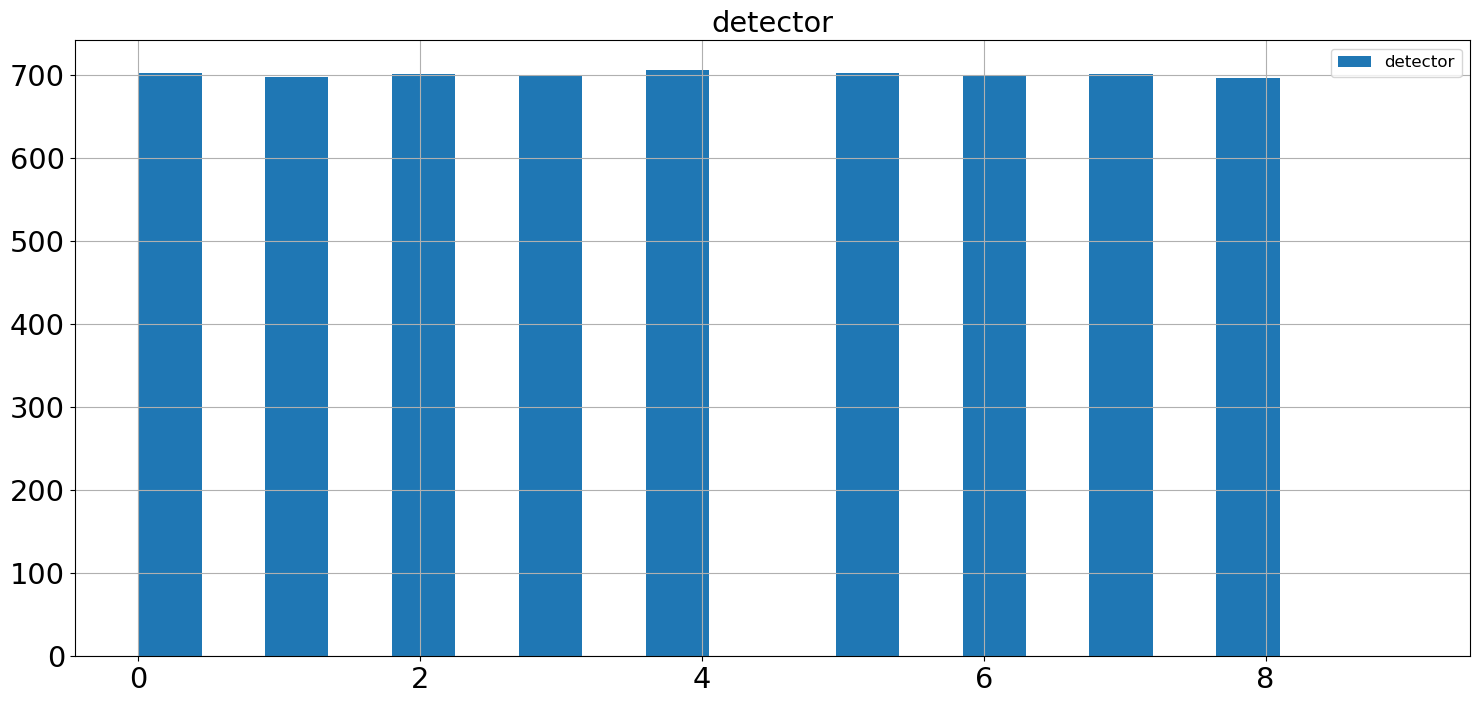

In [21]:
ccd_visit_table[["detector"]].hist(bins=20,range=(0,9),legend=True)

In [22]:
s_size_det = ccd_visit_table[["Vid","ccdVid","detector","tractID","patchID"]].groupby(["detector"]).size()

In [23]:
s_size_det

detector
0    702
1    697
2    701
3    698
4    706
5    702
6    698
7    701
8    696
dtype: int64

In [24]:
s_size_tract = ccd_visit_table[["Vid","ccdVid","detector","tractID","patchID"]].groupby(["tractID","patchID"]).size()

In [25]:
s_size_tract

tractID  patchID
0        0          17
2494     103         1
         119         5
         120         3
         121         1
                    ..
9880     180         6
         193         1
         194         5
         195         2
         196         1
Length: 751, dtype: int64

In [26]:
visit_table = butler.get('visitTable', dataId={'instrument': instrument}, collections = collections )    
visit_table

,visit,physical_filter,band,ra,dec,decl,skyRotation,azimuth,altitude,zenithDistance,airmass,expTime,expMidpt,expMidptMJD,obsStart,obsStartMJD
visitId,,,,,,,,,,,,,,,,
7024040300001,7024040300001,r_03,r,124.952559,-14.949878,-14.949878,121.461718,35.491938,71.834271,18.165729,1.053151,30.0,2024-04-03 23:30:29.555496,60403.979509,2024-04-03 23:30:14.555496,60403.979335
7024040300002,7024040300002,r_03,r,124.951436,-15.100181,-15.100181,120.374849,35.272148,72.051278,17.948722,1.051239,30.0,2024-04-03 23:31:11.531491,60403.979995,2024-04-03 23:30:56.531491,60403.979821
7024040300003,7024040300003,r_03,r,124.879501,-14.930244,-14.930244,118.613777,34.330998,72.025829,17.974171,1.051485,30.0,2024-04-03 23:31:53.026497,60403.980475,2024-04-03 23:31:38.026497,60403.980301
7024040300004,7024040300004,r_03,r,124.908570,-14.963176,-14.963176,117.403385,33.995775,72.123915,17.876085,1.050985,30.0,2024-04-03 23:32:34.286506,60403.980952,2024-04-03 23:32:19.286506,60403.980779
7024040300005,7024040300005,r_03,r,124.794880,-14.977465,-14.977465,115.827267,33.231582,72.273284,17.726716,1.050191,30.0,2024-04-03 23:33:15.695995,60403.981432,2024-04-03 23:33:00.695995,60403.981258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7024040300776,7024040300776,r_03,r,299.899487,-41.082086,-41.082086,137.613459,127.405108,69.374551,20.625449,1.105687,30.0,2024-04-04 10:25:08.351501,60404.434124,2024-04-04 10:24:53.351501,60404.433951
7024040300777,7024040300777,r_03,r,300.148720,-41.064252,-41.064252,136.462356,127.290776,69.330282,20.669718,1.106335,30.0,2024-04-04 10:25:49.848998,60404.434605,2024-04-04 10:25:34.848998,60404.434431
7024040300778,7024040300778,r_03,r,300.113140,-40.822769,-40.822769,135.169026,126.849875,69.574319,20.425681,1.104543,30.0,2024-04-04 10:26:31.413499,60404.435086,2024-04-04 10:26:16.413499,60404.434912


In [27]:
visit_table[["visit"]].sort_values(by="visit")

,visit
visitId,
7024040300001,7024040300001
7024040300002,7024040300002
7024040300003,7024040300003
7024040300004,7024040300004
7024040300005,7024040300005
...,...
7024040300776,7024040300776
7024040300777,7024040300777
7024040300778,7024040300778


In [30]:
df = ccd_visit_table

## Find Tracts involved for each date

In [31]:
df_stat_pertract = df.groupby(by=["nightObs","tractID"]).count()["visitId"]
df_stat_pertract

KeyError: 'nightObs'

In [ ]:
ax = df_stat_pertract.unstack(level=1).plot(kind='bar', subplots=False, rot=90,figsize=(16,8),grid=True)
plt.tight_layout()

In [ ]:
ax = df_stat_pertract.unstack(level=1).plot(kind='bar', subplots=True, rot=90,figsize=(16,30),grid=True)
plt.tight_layout()

## Pandas series

In [ ]:
ccd_visit_table_counts = df.groupby(['nightObs','band']).count()["visitId"]
ccd_visit_table_counts_g = df[df["band"] == "g"].groupby(['nightObs']).count()["visitId"]
ccd_visit_table_counts_r = df[df["band"] == "r"].groupby(['nightObs']).count()["visitId"]
ccd_visit_table_counts_i = df[df["band"] == "i"].groupby(['nightObs']).count()["visitId"]
ccd_visit_table_counts_z = df[df["band"] == "z"].groupby(['nightObs']).count()["visitId"]
ccd_visit_table_counts_y = df[df["band"] == "y"].groupby(['nightObs']).count()["visitId"]

In [ ]:
print(ccd_visit_table_counts)

In [ ]:
ccd_visit_table_counts_z

In [ ]:
ccd_visit_table_counts_y

### Observation date-time

In [ ]:
def convertNumToDatestr(num):
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)

In [ ]:
[convertNumToDatestr(num) for num in ccd_visit_table_counts_g.index ]

In [ ]:
dt_g = pd.to_datetime([convertNumToDatestr(num) for num in ccd_visit_table_counts_g.index])
dt_r = pd.to_datetime([convertNumToDatestr(num) for num in ccd_visit_table_counts_r.index ])
dt_i = pd.to_datetime([convertNumToDatestr(num) for num in ccd_visit_table_counts_i.index ])
dt_z = pd.to_datetime([convertNumToDatestr(num) for num in ccd_visit_table_counts_z.index ])
dt_y = pd.to_datetime([convertNumToDatestr(num) for num in ccd_visit_table_counts_y.index ])

### observation counts

In [ ]:
n_g = ccd_visit_table_counts_g.values
n_r = ccd_visit_table_counts_r.values
n_i = ccd_visit_table_counts_i.values
n_z = ccd_visit_table_counts_z.values
n_y = ccd_visit_table_counts_y.values

In [ ]:
n_g_tot = np.sum(n_g)
n_r_tot = np.sum(n_r)
n_i_tot = np.sum(n_i)
n_z_tot = np.sum(n_z)
n_y_tot = np.sum(n_y)

n_g_min = np.min(n_g)
n_r_min = np.min(n_r)
n_i_min = np.min(n_i)
n_z_min = np.min(n_z)
n_y_min = np.min(n_y)

n_g_max = np.max(n_g)
n_r_max = np.max(n_r)
n_i_max = np.max(n_i)
n_z_max = np.max(n_z)
n_y_max = np.max(n_y)

### Observation count sum

In [ ]:
s_g = n_g.cumsum()
s_r = n_r.cumsum()
s_i = n_i.cumsum()
s_z = n_z.cumsum()
s_y = n_y.cumsum()

## Plot

In [ ]:
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 
fig, axs = plt.subplots(5,1,figsize=(16, 10),sharex=True)

ax1,ax2,ax3,ax4,ax5 = axs

# fit 1
#ax.plot(dt,df_spec_visit.values,marker='o', markersize=15,lw=0)
ax1.bar(dt_g,n_g,lw=5,facecolor='g')
ax1.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax1.xaxis.set_minor_locator(day_locator)
ax1.xaxis.set_major_formatter(year_month_formatter)
ax1.grid()

title1 = f"number of phot obs per night in SDSS-g"
ax1.set_title(title1)

#fig.autofmt_xdate() # rotation
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=45, ha='right')

#ax2.bar(dt,df_spec_visit.cumsum().values,lw=5,facecolor='b')
ax2.bar(dt_r,n_r,lw=5,facecolor='r')
ax2.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax2.xaxis.set_minor_locator(day_locator)
ax2.xaxis.set_major_formatter(year_month_formatter)
ax2.grid()

#fig.autofmt_xdate() # rotation
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')
title2 = f"number of phot obs per night in SDSS-r"
ax2.set_title(title2)

#ax2.bar(dt,df_spec_visit.cumsum().values,lw=5,facecolor='b')
ax3.bar(dt_i,n_i,lw=5,facecolor='orange')
ax3.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax3.xaxis.set_minor_locator(day_locator)
ax3.xaxis.set_major_formatter(year_month_formatter)
ax3.grid()

#fig.autofmt_xdate() # rotation
ax3.set_xticks(ax3.get_xticks(), ax3.get_xticklabels(), rotation=45, ha='right')
title3 = f"number of phot obs per night in SDSS-i"
ax3.set_title(title3)

#ax2.bar(dt,df_spec_visit.cumsum().values,lw=5,facecolor='b')
ax4.bar(dt_z,n_z,lw=5,facecolor='grey')
ax4.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax4.xaxis.set_minor_locator(day_locator)
ax4.xaxis.set_major_formatter(year_month_formatter)
ax4.grid()

#fig.autofmt_xdate() # rotation
ax4.set_xticks(ax4.get_xticks(), ax4.get_xticklabels(), rotation=45, ha='right')
title4 = f"number of phot obs per night in SDSS-z"
ax4.set_title(title4)


#ax2.bar(dt,df_spec_visit.cumsum().values,lw=5,facecolor='b')
ax5.bar(dt_y,n_y,lw=5,facecolor='k')
ax5.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax5.xaxis.set_minor_locator(day_locator)
ax5.xaxis.set_major_formatter(year_month_formatter)
ax5.grid()

#fig.autofmt_xdate() # rotation
ax5.set_xticks(ax5.get_xticks(), ax5.get_xticklabels(), rotation=45, ha='right')
title5 = f"number of phot obs per night in SDSS-y"
ax5.set_title(title5)


plt.tight_layout()

In [ ]:
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 
fig, axs = plt.subplots(2,1,figsize=(18, 8),sharex=True)

ax1,ax2 = axs

dt = timedelta(hours=10)

# fit 1
#ax.plot(dt,df_spec_visit.values,marker='o', markersize=15,lw=0)
ax1.bar(dt_g-dt,n_g,lw=5,facecolor='g',label="SDSS-g")
ax1.bar(dt_r,n_r,lw=5,facecolor='r',label="SDSS-r")
ax1.bar(dt_i+dt,n_i,lw=5,facecolor='orange',label="SDSS-i")
ax1.bar(dt_z+2*dt,n_z,lw=5,facecolor='grey',label="SDSS-z")
ax1.bar(dt_y+3*dt,n_y,lw=5,facecolor='k',label="SDSS-y")
ax1.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax1.xaxis.set_minor_locator(day_locator)
ax1.xaxis.set_major_formatter(year_month_formatter)
ax1.grid()
ax1.legend()
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=45, ha='right')

title = f"number of phot obs per night"
ax1.set_title(title)


ax2.bar(dt_g-dt,s_g,lw=5,facecolor='g',label="SDSS-g")
ax2.bar(dt_r,s_r,lw=5,facecolor='r',label="SDSS-r")
ax2.bar(dt_i+dt,s_i,lw=5,facecolor='orange',label="SDSS-i")
ax2.bar(dt_z+2*dt,s_z,lw=5,facecolor='grey',label="SDSS-z")
ax2.bar(dt_y+3*dt,s_y,lw=5,facecolor='k',label="SDSS-y")
ax2.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax2.xaxis.set_minor_locator(day_locator)
ax2.xaxis.set_major_formatter(year_month_formatter)
ax2.grid()
ax2.legend()
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')

title = f"cumulative number of phot obs per night (n_tot_g = {n_g_tot} , n_r_tot = {n_r_tot} , n_i_tot = {n_i_tot} ,  n_z_tot = {n_z_tot}, n_y_tot = {n_y_tot})"
ax2.set_title(title)


plt.tight_layout()